In [56]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns

Only take restaurants into account. We want to find out, what it is what makes restaurants go up or down in rating significantly.

In [2]:
size = 100000
business_chunks = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True,
                    dtype={
                        "business_id": str,
                        "name": str,
                        "address": str,
                        "city": str,
                        "state": str,
                        "postal code": str,
                        "latitude": float,
                        "longitude": float,
                        "stars": float,
                        "review_count": int,
                        "is_open": int
                    }, chunksize=size)

chunk_list = []
for chunk in business_chunks:
    chunk = chunk[chunk['categories'].notnull()]
    
    # only keep restaurants
    chunk = chunk.loc[[('Restaurant' in x) for x in chunk['categories']]]
    
    # only in Vancouver
    chunk = chunk.loc[chunk['city'] == 'Vancouver']
    
    
    # only certain columns
    # chunk = chunk[['business_id', 'name','stars', 'is_open','review_count']]
    
    chunk_list.append(chunk)

restaurants = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)


# EDA on restaurants in Vancouver
A bit of explorative data analysis, to get used to the data and see if our business case is actually valid.

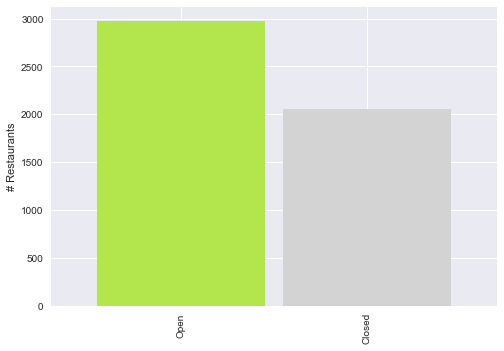

In [212]:
plt.style.use('seaborn')

restaurants['is_open_cat'] = restaurants.is_open.apply(lambda x : 'Open' if x == 1 else 'Closed')

ax = plt.subplot()
restaurants.is_open_cat.value_counts().plot(ax=ax, kind='bar', width=0.9, color=[(0.7,0.9,0.3), 'lightgrey'])
ax.set_ylabel('# Restaurants')
plt.show()

There are a lot of closed restaurants. Let's compare the average star rating.

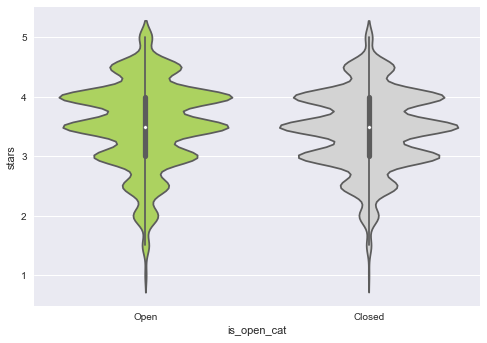

In [64]:
ax = plt.subplot()

my_palette = {"Open": (0.7,0.9,0.3), "Closed": "lightgrey"}

sns.violinplot(x='is_open_cat',y='stars', data=restaurants, ax = ax, palette = my_palette)
plt.show()

The differences between closed and open restaurants is only marginal. I still do expect some differences in the text ratings, though. 

Most users vote around 4 stars. 1 star is extremely seldom (the Canadians are truely polite people 😊). 

Let's now take a look at the restaurants in general. Plot the top 10most occurring categories.

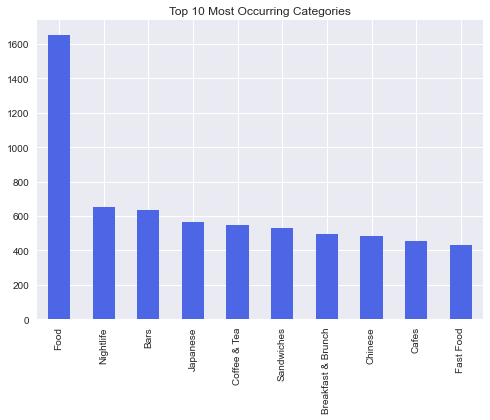

In [114]:
ax = plt.subplot()
categories = restaurants.categories.str.split(', ', expand=True)
categories['business_id'] = restaurants['business_id']
categories.melt('business_id', value_name='category').dropna().sort_values('business_id').query('category != "Restaurants"').category.value_counts()[:10].plot(kind='bar', ax=ax, color=(0.3,0.4,0.9))
ax.set_title('Top 10 Most Occurring Categories')
plt.show()

## Read the reviews
Now read the reviews, to see if they vary over time.

In [88]:
size = 1000000
review_chunks = pd.read_json('../data/yelp_academic_dataset_review.json', lines=True,
                    dtype={
                    "review_id": str,
                    "user_id": str,
                    "business_id": str,
                    "stars": int,
                    "date": str,
                    "text": str,
                    "useful": int,
                    "funny": int,
                    "cool": int,
                }, chunksize=size)

chunk_list = []
for chunk in review_chunks:
    # only keep tips of current or former elite users.
    chunk = chunk[chunk.business_id.isin(restaurants.business_id.unique())]
    chunk_list.append(chunk)

reviews = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

reviews['yearmon'] = reviews['date'].str[0:7]
reviews['year'] = reviews['date'].str[0:4]
reviews['quarter'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d').dt.quarter

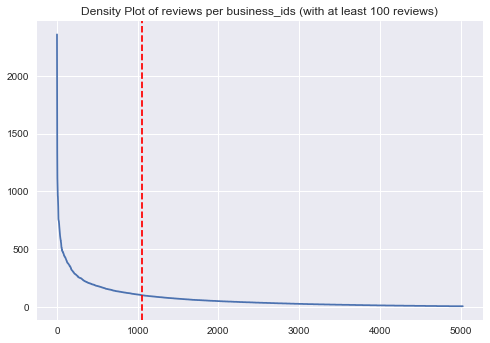

In [155]:
ax = plt.subplot()
line_at = 100

ax.set_title(f'Density Plot of reviews per business_ids (with at least {line_at} reviews)')
business_ids_with_sufficient_reviews = reviews.business_id.value_counts()[reviews.business_id.value_counts() > line_at].index.values
reviews.business_id.value_counts().reset_index()['business_id'].plot(ax=ax)
number_of_businesses_with_sufficient_reviews = sum(reviews.business_id.value_counts() > line_at)
ax.axvline(number_of_businesses_with_sufficient_reviews, linestyle='--', color = 'red')
plt.show()

We have roughly 1000 companies, that have more than 100 reviews. For these, we should be able to get a nice development of star ratings.

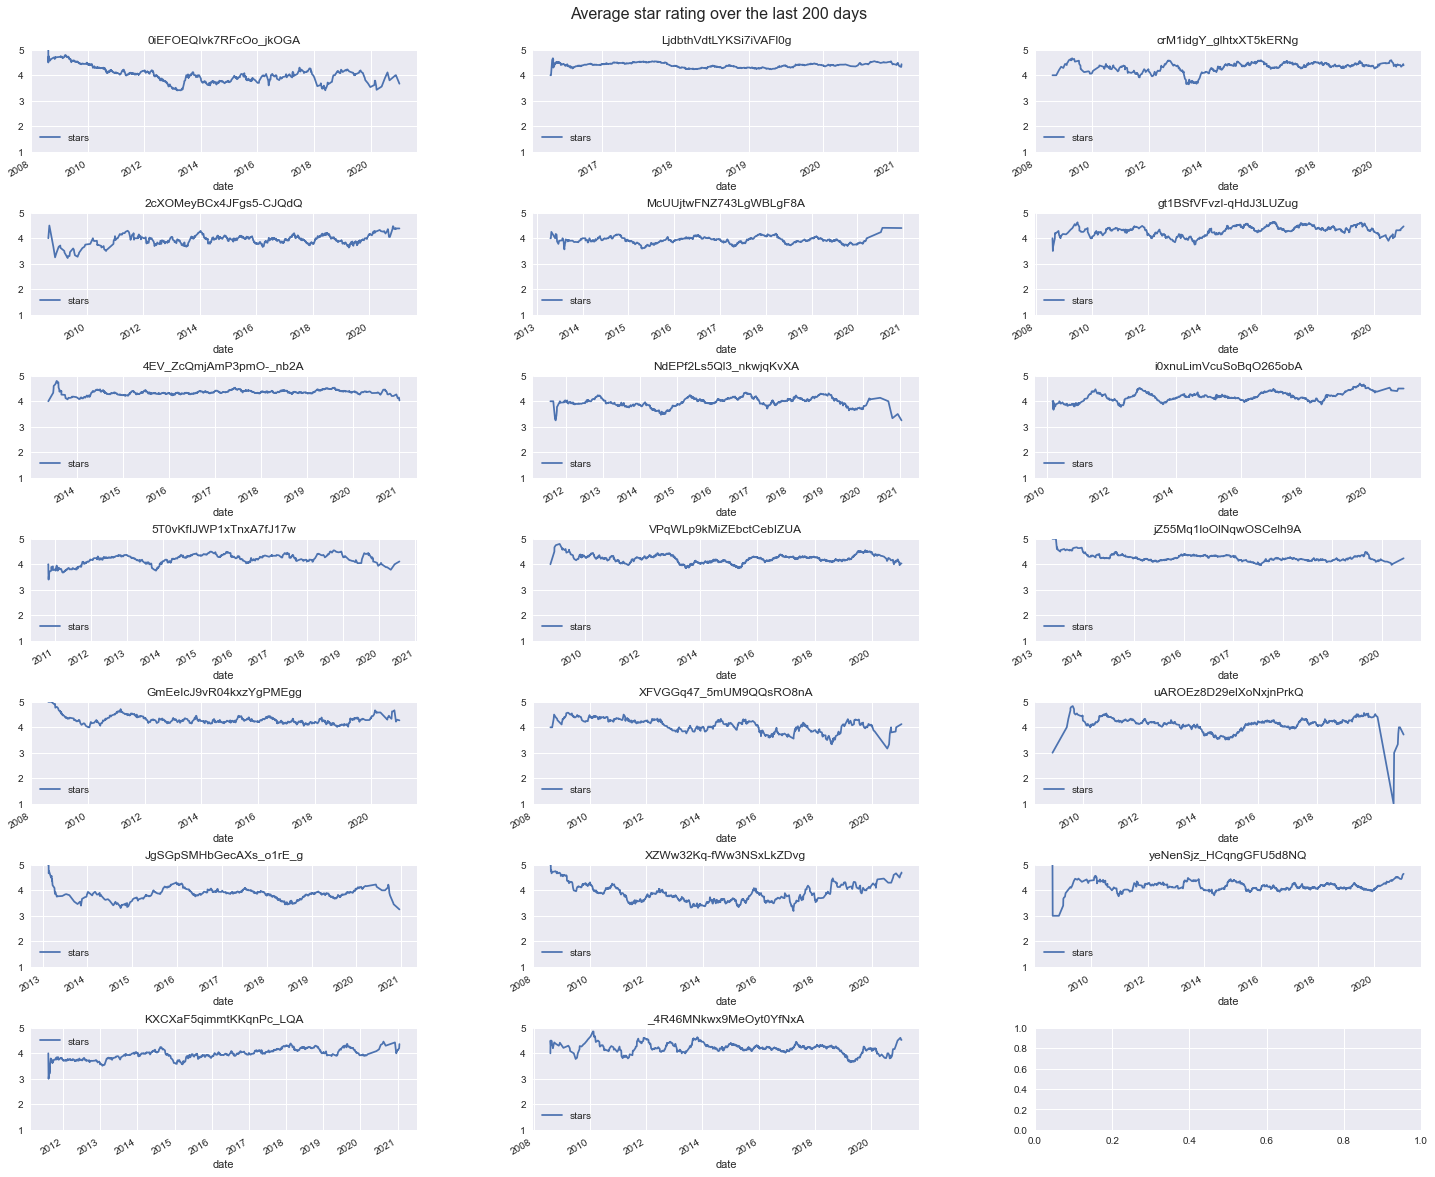

In [214]:
reviews['date'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d')

mean_ratings_top_20 = reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20]), ['business_id', 'stars', 'date']].set_index('date', inplace=False).sort_index().groupby('business_id').rolling(window='200D').agg({'stars': 'mean'})

fig, ax = plt.subplots(7,3, figsize=(20,20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.6, wspace=0.3, top=0.95)
fig.suptitle('Average star rating over the last 200 days', fontsize=16)
y = 0
for i, (name, group) in enumerate(mean_ratings_top_20.groupby('business_id')):
    # calc index
    x = i % 7
    if i != 0 and x == 0:
        y += 1
    
    ax[x,y].set_ylim(1,5)
    group.reset_index().plot(x='date', y='stars', ax=ax[x,y], title=name)
    
    if i ==20:
        break

Some restaurants in this sample vary a bit, but overall they are all pretty much constantly around 4. This might be due to a bias in the users ratings. For example, if a restaurant is well known and has a very good rating, but customers are extremely unhappy, they might resort to rating it 3 stars, whilst at other places they would have rated it 1 star. The _anchor effect_ could be a potential explanation for this behavior.

Additionally, most of the times, users place reviews when they have extreme feelings about the restaurants and will vote accordingly (1 for extremely upset and 5 for extremely happy. Thus, it is unrealistic for businesses to receive constantly ratings close to 5.

However, if we are able to analyze the true sentiment of the users in their textual review, we might be able to ignore the star rating and add a secondary "__sentiment score__". In combination with topic modeling, we could potentially extract topics and assign the sentiment score to the topics. Thus, we would end up with a more granular scoring for e.g. food, service, atmosphere, etc.

With that score, we might be able to give a more realistic view onto things for the businesses, to try and find out what causes a drop in ratings and what they should be working on. We will deliver this as shown above on a rolling window of the last X days. That way, business owners are able to react more quickly to recent changes in their ratings and find out what they need to be working on.

For users, we might be able to add this as additional filters to the search for restaurants. That way users are able to filter the search results with a more realistic search.

# Implementation Plan
<img src='../resources/implementation_plan.jpg' />

1. Sentiment analysis with VADER. VADER was developed to perform well with texts based on social media and therefore is a great choice for the yelp dataset.
2. Topic extraction with LDA. This requires a bit of preprocessing and finetuning. We expect to end up with topics that are relevant to the restaurant business, e.g. food, service, and atmosphere
3. Topic naming with word embeddings. Usually humans have to name the topics found by LDA. However, we want to be totally crazy and use the transitive features of word embeddings and find topic names based on the top X words per topic.
4. Combining the sentiment with the topics to end up with a list of sentiments per topic.

# Sentiment analysis with VADER

In [284]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import nltk
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [219]:
reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].shape

(21918, 12)

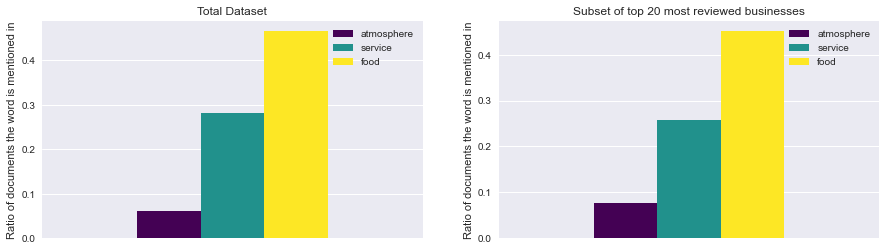

In [263]:
exemplary_occurrences = pd.DataFrame({
    'atmosphere': reviews.text.str.contains('atmosphere').mean(),
    'service': reviews.text.str.contains('service').mean(),
    'food': reviews.text.str.contains('food').mean()
}, index=['Occurences of words'])

exemplary_occurrences_subset = pd.DataFrame({
    'atmosphere': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('atmosphere').mean(),
    'service': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('service').mean(),
    'food': reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])].text.str.contains('food').mean()
}, index=['Occurences of words'])

fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].axes.get_xaxis().set_visible(False)
ax[0].set_ylabel('Ratio of documents the word is mentioned in')
ax[0].set_title('Total Dataset')
exemplary_occurrences.plot(kind='bar', ax=ax[0], colormap='viridis')

ax[1].axes.get_xaxis().set_visible(False)
ax[1].set_ylabel('Ratio of documents the word is mentioned in')
ax[1].set_title('Subset of top 20 most reviewed businesses')
exemplary_occurrences_subset.plot(kind='bar', ax=ax[1], colormap='viridis')

plt.show()

The words ratio is about the same for our subset, so let's use the subset for now to get quicker results

In [264]:
top20_reviews = reviews.loc[reviews.business_id.isin(business_ids_with_sufficient_reviews[:20])]

In [266]:
top20_reviews.assign(tokenized=top20_reviews.text.map(lambda x: tokenize.sent_tokenize(x)))

C:\Users\lukas\AppData\Local\Temp/ipykernel_12588/3443208018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top20_reviews['tokenized'] = top20_reviews.text.map(lambda x: tokenize.sent_tokenize(x))


In [283]:
top20_reviews = top20_reviews.assign(score=top20_reviews.text.map(lambda x : sid.polarity_scores(x)['compound']))

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,yearmon,year,quarter,tokenized,score
1,ucFOnqgaV40oQ2YNyz5ddQ,JHXQEayrDHOWGexs0dCviA,KXCXaF5qimmtKKqnPc_LQA,1,0,0,0,Great coffee and pastries. Baristas are excell...,2018-03-03 23:45:25,2018-03,2018,1,"[Great coffee and pastries., Baristas are exce...",0.7579
4,P320Yt8vFD3yjI34hq-umg,IMfkbLVt_GJfD7zJ9T4fcw,VPqWLp9kMiZEbctCebIZUA,3,0,0,0,"Overall is good, is worth the line up I don't ...",2018-09-25 03:22:50,2018-09,2018,3,"[Overall is good, is worth the line up I don't...",0.8779
5,dVNBiJgZvZpXkUNaWL9Ljw,EuuWkZ_EA2IjsJCPOCt9UA,VPqWLp9kMiZEbctCebIZUA,2,1,1,0,So we sat at the bar after a 45 minute wait. E...,2015-09-23 23:35:46,2015-09,2015,3,"[So we sat at the bar after a 45 minute wait.,...",0.3528
9,VIBVm2mi4ydOaHbah68bzA,vLOApYl6w7K455f_Rfprvw,VPqWLp9kMiZEbctCebIZUA,2,1,0,0,I was trying to decide if I should give two or...,2013-06-24 08:21:19,2013-06,2013,2,[I was trying to decide if I should give two o...,0.9289
21,BU_D1TAU1J3c8SMyDLdNCg,vAfLRIe_AqCw6AAJCWFuGw,VPqWLp9kMiZEbctCebIZUA,4,0,0,0,"Finally, made it out to Cafe Medina and will b...",2010-01-08 01:05:05,2010-01,2010,1,"[Finally, made it out to Cafe Medina and will ...",0.9856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339421,fPjcCeZk-1MvYIG_DpYtvQ,522M-weF78TSm8yOi6MtBA,NdEPf2Ls5Ql3_nkwjqKvXA,4,1,0,0,Decent place to grab some drinks and food. I w...,2018-04-25 15:54:05,2018-04,2018,2,"[Decent place to grab some drinks and food., I...",0.9917
339429,vTOH4kLdOdEXg5OrbrmW1A,YeFVi1I0_GyF3HmOevY9jg,NdEPf2Ls5Ql3_nkwjqKvXA,1,0,0,0,Owners are abusive towards employees and treat...,2020-10-17 20:13:03,2020-10,2020,4,[Owners are abusive towards employees and trea...,-0.3612
339444,kxxp1SisypVW6raZM6PnNg,uxfSeNwFqmC_GgDOm_LosQ,NdEPf2Ls5Ql3_nkwjqKvXA,4,1,0,0,Came here a few times for lunch and dinner and...,2017-07-09 17:14:21,2017-07,2017,3,[Came here a few times for lunch and dinner an...,0.9823
339505,XlsKzJxpkTO83IkUG4ExBg,vxdxGUWjR0D_-SdHMy9bTg,NdEPf2Ls5Ql3_nkwjqKvXA,5,1,0,1,"Fantastic restaurant with a comfortable, dimly...",2015-08-08 17:21:59,2015-08,2015,3,"[Fantastic restaurant with a comfortable, diml...",0.9835


In [281]:
top20_reviews[['text', 'score']]

,text,score
1,Great coffee and pastries. Baristas are excell...,0.7579
4,"Overall is good, is worth the line up I don't ...",0.8779
5,So we sat at the bar after a 45 minute wait. E...,0.3528
9,I was trying to decide if I should give two or...,0.9289
21,"Finally, made it out to Cafe Medina and will b...",0.9856
...,...,...
339421,Decent place to grab some drinks and food. I w...,0.9917
339429,Owners are abusive towards employees and treat...,-0.3612
339444,Came here a few times for lunch and dinner and...,0.9823
339505,"Fantastic restaurant with a comfortable, dimly...",0.9835


__Caveat:__ We should probably do it per sentence, as some sentences have separat topics. E.g. "Baristas are great. All other staff is soooo lost and vacant."

# LDA Topic Modelling
Game Plan for this step:
1. Basic preprocessing (tokenizing, and removing duplicate whitespaces and punctuation)
2. Removal of stop words
3. POS Tagging and filter to only nouns (relevant to topics)
4. Stem words
5. Run LDA on entire review text as a whole

__Caveat:__ We should do this per sentence to get a more fine-grain result. For now, we will stick with this solution, however.

Get the restaurant with the most reviews as an example

In [123]:
most_reviewed_restaurant_ids = restaurants.sort_values('review_count', ascending=False).head(1000)['business_id'].values

In [12]:
most_reviewed_restaurant_id = restaurants.loc[restaurants.review_count == restaurants.review_count.max(), 'business_id'].values[0]
most_reviewed_restaurant_id

'4CxF8c3MB7VAdY8zFb2cZQ'

Now get the corresponding reviews

In [124]:
size = 1000000
review_chunks = pd.read_json('../data/yelp_academic_dataset_review.json', lines=True,
                    dtype={
                    "review_id": str,
                    "user_id": str,
                    "business_id": str,
                    "stars": int,
                    "date": str,
                    "text": str,
                    "useful": int,
                    "funny": int,
                    "cool": int,
                }, chunksize=size)

chunk_list = []
for chunk in review_chunks:
    # only keep tips of current or former elite users.
    chunk = chunk[chunk.business_id.isin(most_reviewed_restaurant_ids)]
    chunk_list.append(chunk)

reviews = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

In [125]:
reviews.shape # should have roughly 9000 for single case, 35k for top 5 restaurants

(1147829, 9)

Check the reviews over time, how the mean varies per month

In [17]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,yearmon
0,X4-EMXS7-XJZ9tuVJhn0-g,lzQLHoJdaMNwiNt76wrc4g,4CxF8c3MB7VAdY8zFb2cZQ,2,5,2,3,I am alway leery of places the trade on schtic...,2011-08-24 21:59:48,2011-08
1,19msT9vUbN1xI17FTsFBOw,s-xMG4eoG1YO0N795PaAiQ,4CxF8c3MB7VAdY8zFb2cZQ,4,0,0,0,"It's a must when visitors come to town, not th...",2015-10-07 21:39:23,2015-10
2,GAzyhQ6FquMy-W_IM55NcA,9tW7SD-mL6PlHIOvORVMig,4CxF8c3MB7VAdY8zFb2cZQ,4,0,0,0,The maple bacon bar is to die for. I live in P...,2012-07-16 02:07:27,2012-07
3,o047kXCHybKL6vUYFcUOHg,YP5RiJiv0nOpyo0tHYkdwA,4CxF8c3MB7VAdY8zFb2cZQ,3,1,0,0,Innovative types of donuts but a bit priceyy (...,2016-10-13 23:56:59,2016-10
4,5DYJBTm9V9w0xcrXVcqmRg,8ZoyTgGq0wUHDNISHU7D0Q,4CxF8c3MB7VAdY8zFb2cZQ,4,0,0,0,"Love! Bacon-Maple Bars are my favorite, but s...",2014-10-11 06:52:26,2014-10


In [126]:
reviews['yearmon'] = reviews['date'].str[0:7]
reviews['year'] = reviews['date'].str[0:4]
reviews['quarter'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d').dt.quarter

<AxesSubplot:>

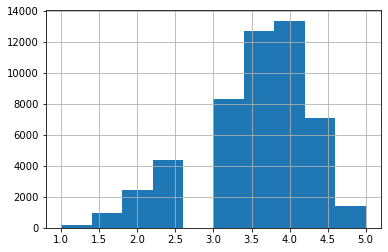

In [127]:
# plot overall star ratings
restaurants.stars.hist()

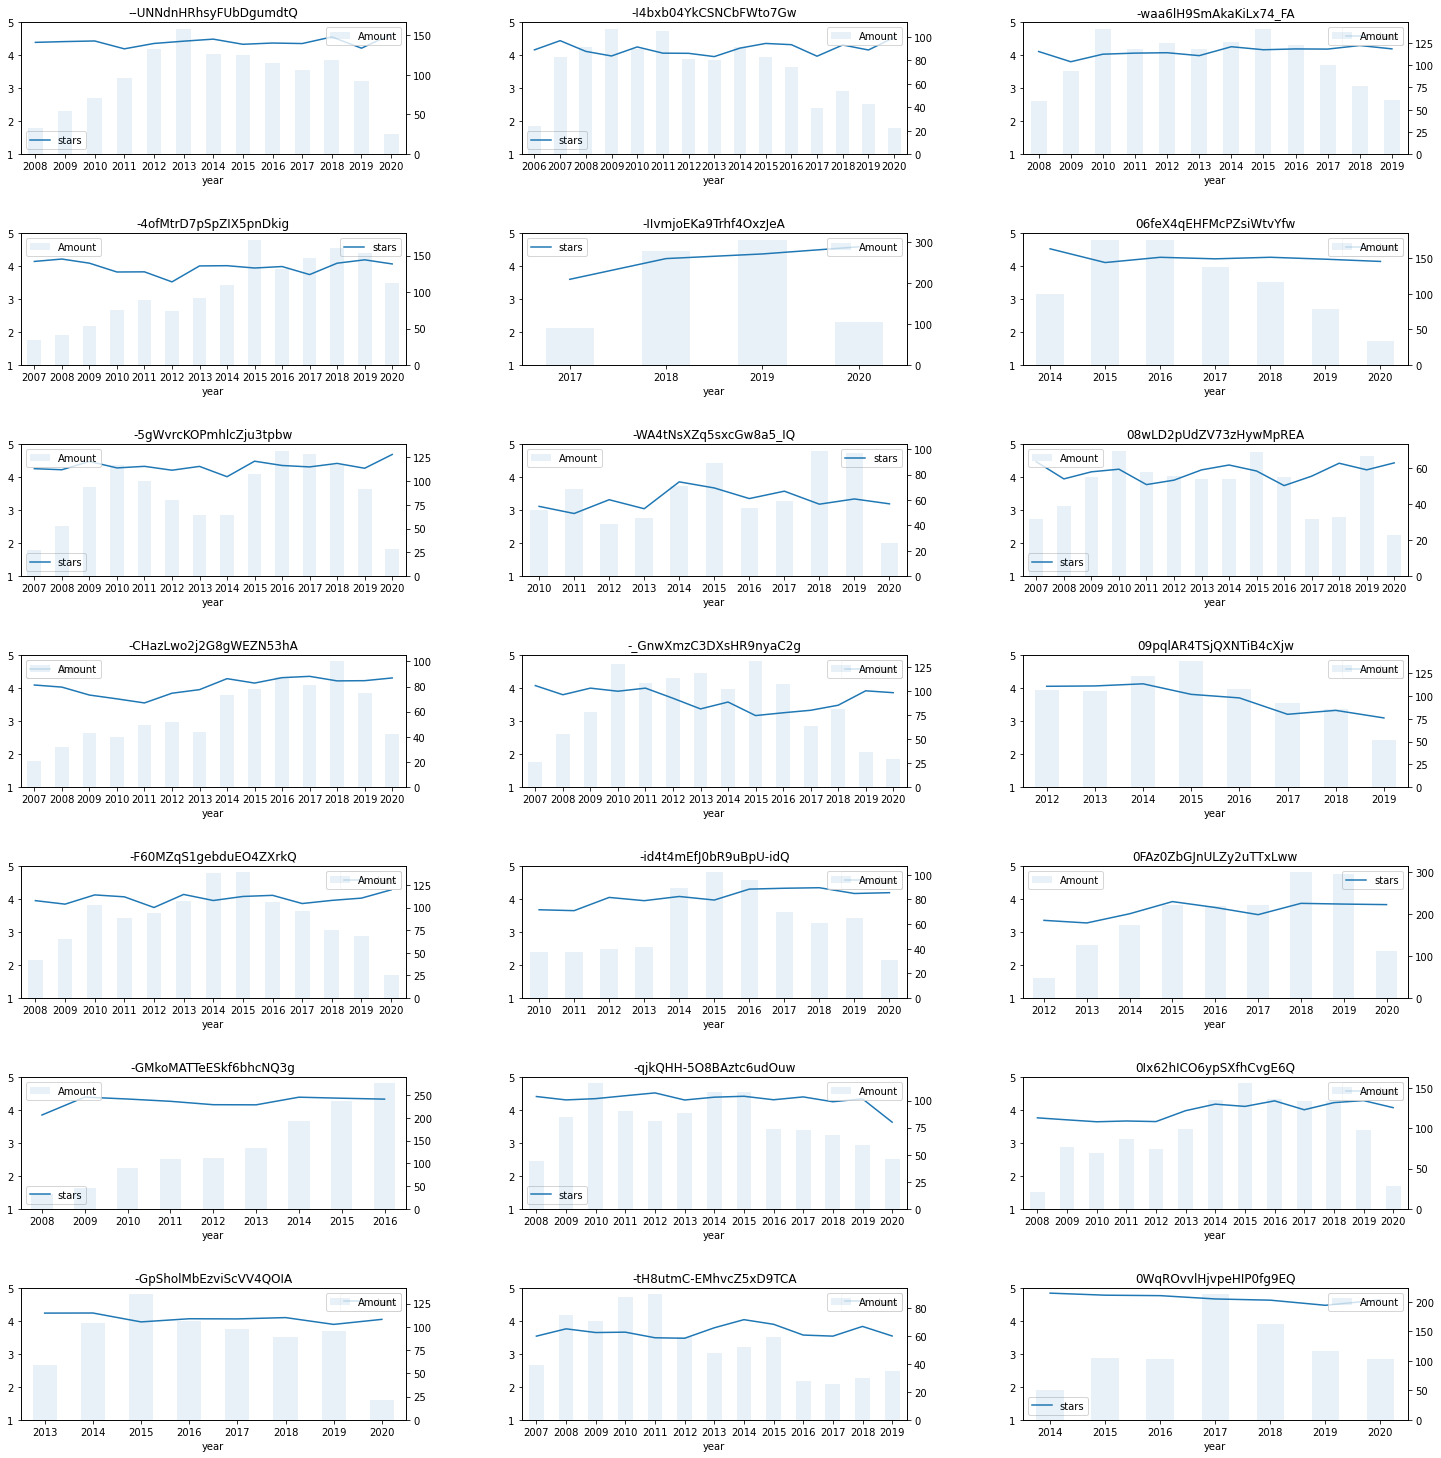

In [128]:
fig, ax = plt.subplots(7,3, figsize=(20,20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.6, wspace=0.3)

y = 0
for i, (name, group) in enumerate(reviews.groupby(['business_id', 'year']).agg({"stars": "mean", "text": "count"}).reset_index().groupby('business_id')):
    # calc index
    x = i % 7
    if i != 0 and x == 0:
        y += 1
    group = group[group['text'] > 20]
    
    ax[x,y].set_ylim(1,5)
    group.plot(x='year', y='stars', ax=ax[x,y], title=name)
    
    twin = ax[x,y].twinx()
    
    group.plot(x='year', y='text', ax=twin, label='Amount', kind='bar', alpha=0.1)
    
    if i ==20:
        break

Most restaurants dont vary a whole lot and have a rather constant rating. Let's find out if there actually are restaurants where the rating varies with at least 1 star difference overall. 

In [130]:
reviews.groupby(['business_id', 'year']).agg({"stars": "mean", "text": "count"}).query('text > 20').reset_index().groupby('business_id').agg({"stars": lambda x: x.max() - x.min()}).sort_values("stars", ascending=False)


,stars
business_id,
zNqQSYafieEgxB2nZ8yAFQ,2.039706
4x3SvUgv6Di5Vs-hBN5HXw,1.978135
OFHWBXs5-UyEYf0-MrFDUw,1.837662
tt9gTrwhd_3v6AoQesEZmw,1.766530
smiGOZuyboXfc8LyC2jXpg,1.734345
...,...
PrWSjn4a8o4dHoqKs53GBA,0.113111
r1VBBIelTdjwtqE4pKwghA,0.090837
ERoYrBHNmTEEChY3RGaOGQ,0.082011


There are quite a few businesses whos rating changed substantially over time. Let us analyze the main drivers based on reviews (as the other data is not historized for us).

We will run LDA on the data for the different years, to hopefully spot the differences as mentioned in the topics. For this we will use the codeword LDA model proposed by Linhi.

We will apply it with a moving average window / or per year. I dont know yet. Hopefully we can then see the main topic assignments change over time

In [131]:
reviews.groupby(['business_id', 'year']).agg({"stars": "mean", "text": "count"}).reset_index().query("business_id == 'zNqQSYafieEgxB2nZ8yAFQ'")

,business_id,year,stars,text
12444,zNqQSYafieEgxB2nZ8yAFQ,2006,3.250000,4
12445,zNqQSYafieEgxB2nZ8yAFQ,2007,4.111111,18
12446,zNqQSYafieEgxB2nZ8yAFQ,2008,3.517241,29
12447,zNqQSYafieEgxB2nZ8yAFQ,2009,3.607143,56
12448,zNqQSYafieEgxB2nZ8yAFQ,2010,3.711340,97
12449,zNqQSYafieEgxB2nZ8yAFQ,2011,3.764706,136
12450,zNqQSYafieEgxB2nZ8yAFQ,2012,3.466102,118
12451,zNqQSYafieEgxB2nZ8yAFQ,2013,3.323308,133
12452,zNqQSYafieEgxB2nZ8yAFQ,2014,3.383648,159
12453,zNqQSYafieEgxB2nZ8yAFQ,2015,3.239234,209


We need to analyze all reviews at once with the LDA und VADER model, to get valid results

In [206]:
breview = reviews[reviews['business_id'] == 'zNqQSYafieEgxB2nZ8yAFQ']
breview.shape

breview = reviews

In [208]:
import re
# Remove punctuation
breview['text_processed'] = breview['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
breview['text_processed'] = breview['text_processed'].map(lambda x: x.lower())

breview['text_processed'].head()



In [213]:
from tqdm import tqdm

tqdm.pandas()  

import gensim
from gensim.utils import simple_preprocess
import nltk

stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


# make this more efficient with a dict to map each word to the preprocessed value.
mapdict = {}
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if mapdict.get(token):
            return mapdict.get(token)
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            prepped_word = lemmatize_stemming(token)
            result.append(prepped_word)
            mapdict['token'] = prepped_word
    return result


data = breview.text_processed[0:50000].progress_map(preprocess).values.tolist()

In [214]:
# make this more efficient with a dict to map each word to the preprocessed value.
mapdict = {}
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if mapdict.get(token):
            return mapdict.get(token)
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            prepped_word = lemmatize_stemming(token)
            result.append(prepped_word)
            mapdict['token'] = prepped_word
    return result


In [ ]:
breview.shape

In [215]:
data_words = list(sent_to_words(data))# remove stop words

print(data_words[:1][0][:30])

['food', 'great', 'servic', 'manag', 'staff', 'super', 'draw', 'restaur', 'super', 'loud', 'snag', 'patio', 'tabl']


In [216]:
text_file = open("../data/positives.txt", "r")
positives = [s.replace('\n', '') for s in text_file.readlines()]


text_file = open("../data/negatives.txt", "r")
negatives = [s.replace('\n', '') for s in text_file.readlines()]


In [217]:
# stem negatives and positives
positives = list(set([preprocess(p)[0] for p in positives if preprocess(p) != []]))
positives.sort()

negatives = list(set([preprocess(n)[0] for n in negatives if preprocess(n) != []]))
negatives.sort()

In [188]:
new_data_words = []
for sentence in data_words:
    new_sentence = []
    for word in sentence:
        new_sentence.append(word)
        if word in positives and np.random.random() > 0.9:
            new_sentence.append('GOOD_REVIEW')
        elif word in negatives and np.random.random() > 0.9:
            new_sentence.append('BAD_REVIEW')
    new_data_words.append(new_sentence)


In [219]:
print(new_data_words[:10])

[['food', 'great', 'servic', 'manag', 'staff', 'super', 'draw', 'restaur', 'super', 'loud', 'snag', 'patio', 'tabl'], ['twice', 'good', 'food', 'servic', 'time', 'burger', 'caramel', 'onion', 'wine', 'sauc', 'believ', 'blue', 'chees', 'time', 'excel', 'right', 'size', 'hate', 'go', 'order', 'burger', 'bigger', 'head', 'finish', 'half', 'flip', 'burger', 'size', 'home', 'second', 'time', 'go', 'limit', 'time', 'season', 'offer', 'venison', 'burger', 'shoot', 'kind', 'chees', 'remind', 'brie', 'sweet', 'syrupi', 'sauc', 'overal', 'good', 'onion', 'ring', 'possibl', 'best', 'onion', 'ring', 'thing', 'like', 'flip', 'atmospher', 'layout', 'tabl', 'guess', 'go', 'trendi', 'upscal', 'make', 'feel', 'school', 'cafeteria', 'high', 'school', 'like', 'long', 'white', 'tabl', 'shove', 'uncomfort', 'modern', 'look', 'plastic', 'chair', 'kind', 'look', 'like', 'come', 'ikea', 'pretti', 'loud', 'absorb', 'sound', 'like', 'school', 'cafeteria', 'time', 'coupl', 'women', 'small', 'children', 'idea', '

In [218]:
new_data_words = data_words

Now train LDA

In [220]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(new_data_words)

# Create Corpus
texts = new_data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1)]


In [221]:
from pprint import pprint

# number of topics
num_topics = 8

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"food" + 0.013*"good" + 0.012*"order" + 0.012*"come" + 0.011*"place" '
  '+ 0.010*"great" + 0.010*"time" + 0.009*"like" + 0.008*"restaur" + '
  '0.008*"love"'),
 (1,
  '0.017*"like" + 0.013*"good" + 0.009*"donut" + 0.009*"place" + 0.007*"food" '
  '+ 0.007*"time" + 0.007*"order" + 0.006*"go" + 0.005*"come" + '
  '0.005*"servic"'),
 (2,
  '0.029*"good" + 0.024*"food" + 0.018*"great" + 0.017*"place" + '
  '0.012*"servic" + 0.009*"restaur" + 0.008*"best" + 0.008*"come" + '
  '0.008*"pretti" + 0.008*"time"'),
 (3,
  '0.027*"place" + 0.021*"food" + 0.014*"great" + 0.014*"love" + 0.011*"good" '
  '+ 0.009*"wait" + 0.009*"friend" + 0.008*"come" + 0.008*"fri" + '
  '0.008*"like"'),
 (4,
  '0.018*"like" + 0.017*"good" + 0.014*"place" + 0.013*"great" + '
  '0.010*"burger" + 0.010*"food" + 0.009*"delici" + 0.008*"order" + '
  '0.008*"time" + 0.008*"donut"'),
 (5,
  '0.019*"food" + 0.013*"time" + 0.012*"place" + 0.012*"chicken" + '
  '0.012*"servic" + 0.010*"order" + 0.010*"good" + 0

In [223]:
import pyLDAvis.gensim_models
import pickle 
import os
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('../results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, '../results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\anaconda3\envs\yelp\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003188 -0.001043       1        1  21.363887
5     -0.019873  0.017386       2        1  14.117849
7     -0.009158  0.007429       3        1  13.243689
6     -0.000645 -0.019334       4        1  12.725298
2     -0.016594 -0.001645       5        1  11.668086
3     -0.013045 -0.003778       6        1  10.268402
4      0.024796 -0.021995       7        1   9.682069
1      0.037708  0.022981       8        1   6.930721, topic_info=        Term          Freq         Total Category  logprob  loglift
21    burger  11770.000000  11770.000000  Default  30.0000  30.0000
187    donut   6684.000000   6684.000000  Default  29.0000  29.0000
38      good  32909.000000  32909.000000  Default  28.0000  28.0000
52      like  19449.000000  19449.000000  Default  27.0000  27.0000
63     place  29978.000000  29978.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
2      great    697.434459  25014.574814   Topic8  -5.3485  -0.9106
6    restaur    518.925714  12927.807888   Topic8  -5.6442  -0.5462
57      menu    496.011089   9202.738101   Topic8  -5.6893  -0.2515
55      look    474.014295   6781.503711   Topic8  -5.7347   0.0085
110   delici    485.652308  12036.726668   Topic8  -5.7104  -0.5410

[742 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
16945      8  0.902709          abbi
628        1  0.168074       absolut
628        2  0.126340       absolut
628        3  0.146069       absolut
628        4  0.106232       absolut
...      ...       ...           ...
6281       5  0.714433        zydeco
22088      6  0.671830    ゆっくり食へていると
22089      6  0.671501       ハンクーハーて
22091      6  0.671474  手打ち麺はのひやすいのて
22092      6  0.671260     結論から述へますと

[2231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 8, 7, 3, 4, 5, 2])

Two things I realize.

1. My dataset is too biased on restaurants with good ratings (we have only the top restaurants, and they usually have high ratings, if they have so many, it means many ppl go there and therefore it must not be shabby)
2. LDA could possibly perform better, if I only train it on nouns and use VADER for sentiment regarding those nouns. Maybe then I am able to split 

In [222]:
#importing wordtovec embeddings 
from gensim.models import KeyedVectors
pretrained_embeddings_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

KeyboardInterrupt: 

In [27]:
import matplotlib.pyplot as plt

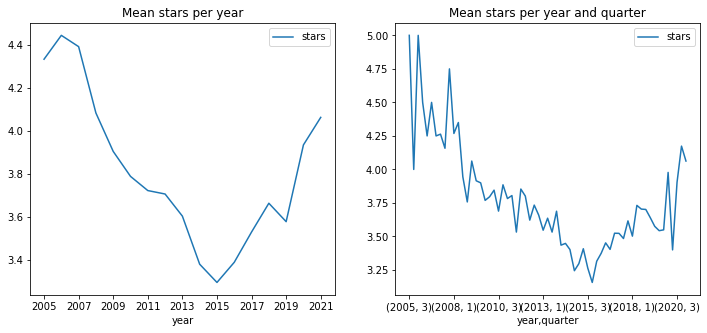

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

reviews['year'] = reviews['date'].str[0:4]
reviews['quarter'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d').dt.quarter

reviews.groupby('year').agg({"stars": "mean", "business_id": "count"}).plot(y='stars', use_index=True, ax = ax[0])
ax[0].set_title('Mean stars per year') 
reviews.groupby(['year', 'quarter']).agg({"stars": "mean", "business_id": "count"}).plot(y='stars', use_index=True, ax = ax[1])
ax[1].set_title('Mean stars per year and quarter')
plt.show()

As this is already the most reviewed restaurant, I would say smoothing to year would be a valid approach, although ratings do not vary a whole lot in this example for year quarter as well. 

Let's analyze this example, as to what topics were most discussed by the users in a given year or quarter.

For topic extraction, we will be using LDA, but we will extend it as Shin Linshi proposed in his work [[1]](TOBEADDED)

In [35]:
reviews['text']

0       I am alway leery of places the trade on schtic...
1       It's a must when visitors come to town, not th...
2       The maple bacon bar is to die for. I live in P...
3       Innovative types of donuts but a bit priceyy (...
4       Love!  Bacon-Maple Bars are my favorite, but s...
                              ...                        
9290    Order ahead for curbside pickup.  They have yu...
9291    Best doughnuts I've had in a long time...maybe...
9292    The VooDoo experience is a must do in Portland...
9293    Not sure if the wait is worth the donuts. They...
9294    These guys did a really good job managing the ...
Name: text, Length: 9295, dtype: object

In [51]:
photos.label.unique()

array(['drink', 'food', 'interior', 'outside', 'menu'], dtype=object)

In [52]:
photos.shape

(200000, 4)